## Susceptible-Infected-Recovered-Deceased model

The susceptible population $NS(t)$ decreases through contact with infected, at a rate given by $\lambda$:

\begin{equation}
\frac{d(NS)}{dt} = -\lambda S N I
\end{equation}

$\lambda$ is the "daily contact rate", which means that if everyone were suceptible and uninfected, one infected person would infect $\lambda$ people per day. So the average number of susceptibles infected by an infectious person per day is $\lambda S$.

The infected population $NI(t)$ increases through contact with infected (at a rate set by $\lambda$), decreases through recovery, at a rate $\gamma$, and also decreases through death, at a rate $\mu$.

\begin{equation}
\frac{d(NI)}{dt} = \lambda S N I - \gamma N I - \mu N I
\end{equation}

What does $\gamma$ mean? Individuals recover and are removed from the infective class at a rate proportional to the number of infectives with proportionality constant $\gamma$, called the daily recovery removal rate.

The latent period is zero (it is defined as the period between the time of exposure and the time when infectiousness begins).
Thus the proportion of individuals exposed (and immediately infective) at time $t_0$ who are still infective at time $t_0 + t$ is $\exp(-\gamma t)$, and the average period of infectivity is $P=1/\gamma$.

The recovered population $NR(t)$ increases when members of the infected population recover. We assume (for now) that all recovered people are henceforth immune to being infected a second time.

\begin{equation}
\frac{d(NR)}{dt} = \gamma I N
\end{equation}

The deceased population $ND(t)$ increases through death at a rate $\mu$
\begin{equation}
\frac{d(ND)}{dt} = \mu I N
\end{equation}

Members of the infected population leave $I(t)$ either by recovering (at a rate $\gamma$), or dying (at a rate $\mu$).
Therefore the chance of an infected individual dying (the average lethality) is $L=\mu/\gamma$.

The "basic reproductive number" (also known as "contact number") $R_0$ is defined as $R_0=\lambda / (\gamma + \mu)$. This comes from the fact that accounting for the deaths of infected gives a death-adjusted average period of infectivity of $1/(\gamma + \mu)$, and multiplying that time period by the daily contact rate $\gamma$.

The fact that the membership of all groups together must add up to the total population is expressed as
\begin{equation}
NS + NI + NR + ND = N
\end{equation}
We've also assumed that the total population is constant (including deceased), and that the epidemic occurs in a timeframe much shorter than that over which natural births and deaths significantly affect any of the populations.

Now we can simplify our equations by dividing through by $N$,(and writing the parameters in terms of the more intuitive basic reproduction rate $R_0$, average period of infectivity $P$, and average lethality $L$):

\begin{align}
\frac{dS}{dt} & = -\lambda S I \\
\frac{dI}{dt} & = \lambda S I - \gamma I - \mu I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dD}{dt} & = \mu I \\
1 & = S + I + R + D
\end{align}

## Modelling the coronavirus

Okay let's try and model the coronavirus by solving these equations.

Our equations are a system of linear ordinary differential equations, and we will start from a set of known initial values, so we're going to need `scipy`'s [`integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function. 

In fact, scipy has an example we can follow that is extremely similar, ["Modelling a zombie apocalypse"](https://scipy-cookbook.readthedocs.io/items/Zombie_Apocalypse_ODEINT.html).

Let's write out the equations for the derivatives we need to calculate.

In [12]:
def dSdt(S, I):
    return -lamb*S*I

def dIdt(S, I):
    return lamb*S*I - gamma*I - mu*I

def dRdt(I):
    return gamma*I

def dDdt(I):
    return mu*I

### Population parameters

In [23]:
# Reported UK coronavirus numbers on 15th March 2020
N = 66440000    # population
cases = 1391    # total reported cases including resolved
deaths = 35
recovered = 20

t0 = 0
tf = 200        # number of days to run simulation for
t_span = (0, tf)

R0 = 20/N
D0 = 35/N
S0 = (N - cases)/N
I0 = 1 - S0 - R0 - D0
y0 = [S0, I0, R0, D0]

### Virus parameters

In [14]:
R_0 = 2.6  # Basic Reproductive Rate [people]
L = 0.035  # Case Fatality Rate [fraction]
P = 14     # Average infectious period [days] (should really be split up by case severity)

gamma = 1 / P
mu = gamma * L
lamb = R_0 * (gamma + mu)

In [21]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def rhs(t, y):
    S, I, R, D = y
    return [dSdt(S, I),
            dIdt(S, I), 
            dRdt(I),
            dDdt(I)]

soln = solve_ivp(rhs, t_span, y0, t_eval=np.linspace(t0, tf))

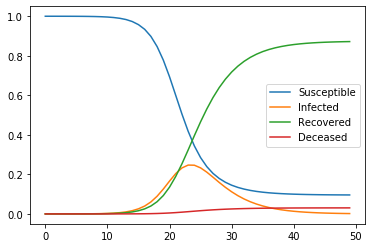

In [27]:
S, I, R, D = soln.y

fig, ax = plt.subplots()
ax.plot(S, label='Susceptible')
ax.plot(I, label='Infected')
ax.plot(R, label='Recovered')
ax.plot(D, label='Deceased')
plt.legend()

## Social distancing

How can social distancing help? 

First we need to include it in the model.
Social distancing effectively reduces $R_0$. If $R_0=0$ (everyone lives alone in a box) then there would be no new infections, and the disease would die out once all the infected had either recovered or died.

If $R_0 < 1$ then new people will still be infected, but not fast enough to sustain the virus, and the contagion will decay away.

But if $R_0>1$, even if only a bit greater, than the virus will still grow exponentially.
It will grow more slowly, but will still pick up pace, becoming faster and faster.

So why do social distancing? If we can decrease $R_0$, in other words we can `#flattenthecurve`.

## Lockdown policies

But just changing $R_0$ overall isn't realistic, it assumes that as soon as the virus was discovered, everyone who is near it practices social distancing immediately and indefinitely.
What is more realistic is that once it's realised that the disease could cause an epidemic, governments encourage (or enforce) varying degrees of social distancing through policies like quarantining, lockdowns, banning large events, and working from home.

How can we parameterise a change in the effectiveness of social distancing through policies like these?
Let's try adjusting $R_0$ using a "quarantine parameter" $Q$.
When $Q=0$ then the disease spreads freely, but when $Q=1$ we are on total lockdown and the disease can't spread at all.

We can represent this by changing our equations for the fraction of susceptible and infected people to

\begin{align}
\frac{dS}{dt} & = -(\lambda - Q) S I \\
\frac{dI}{dt} & = (\lambda - Q) S I - \gamma I - \mu I
\end{align}

These policies might be implemented only once the virus has been spreading for a while.

Or perhaps these policies will only be ramped up when there are lots of people infected. 

## Herd immunity